In [2]:
import numpy as np
from IPython.utils.text import columnize
from numpy.ma.core import array
from pandas.core.interchange.dataframe_protocol import DataFrame

from scipy.stats import ttest_ind
from sklearn.preprocessing import StandardScaler
from os import path
from rdkit import Chem
from rdkit.Chem import Descriptors
import pubchempy as pcp
import ssl
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    # Legacy Python that doesn't verify HTTPS certificates by default
    pass
else:
    # Handle target environment that doesn't support HTTPS verification
    ssl._create_default_https_context = _create_unverified_https_context
    
    
    
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning)    

In [4]:
#Добавляем дескрипторы из PCP, которых нет в RDkit
properties = ['XLogP',                # Коэффициент распределения октанол-вода (логарифмическое значение)
    'ExactMass',            # Точная масса
    'MonoisotopicMass',     # Моноизотопная масса
    'TPSA',                 # Полярная площадь поверхности
    'Complexity',           # Сложность структуры
    'Charge',               # Заряд молекулы
    'HBondDonorCount',      # Количество доноров водородных связей
    'HBondAcceptorCount',   # Количество акцепторов водородных связей
    'RotatableBondCount',   # Количество вращаемых связей
    'HeavyAtomCount',       # Количество тяжелых атомо
    'IsotopeAtomCount',     # Количество атомов изотопов
    'AtomStereoCount',      # Общее количество стереоатомов
    'DefinedAtomStereoCount',   # Определенное количество стереоатомов
    'UndefinedAtomStereoCount', # Неопределенное количество стереоатомов
    'BondStereoCount',          # Общее количество стереосвязей
    'DefinedBondStereoCount',   # Определенное количество стереосвязей
    'UndefinedBondStereoCount', # Неопределенное количество стереосвязей
    'CovalentUnitCount'        # Количество ковалентных единиц
]

df = pd.read_csv(path.join("data", "data.csv"))

In [4]:
# Преобразуем нужные столбцы в строковый формат, на всякий случай
for col in df.iloc[:, 0:2]:
    df[col] = df[col].astype(str)
df

,mol_id,smiles,A,B,C,mu,alpha,homo,lumo,gap,...,zpve,u0,u298,h298,g298,cv,u0_atom,u298_atom,h298_atom,g298_atom
0,gdb_3116,N#CC12CC1CO2,5.99438,2.27301,1.94738,4.5933,55.81,-0.2627,-0.0086,0.2541,...,0.090625,-323.338627,-323.332830,-323.331885,-323.368166,21.459,-1226.756250,-1233.784350,-1240.302914,-1147.410874
1,gdb_117880,COCC(O)C#CC=O,2.32923,0.75737,0.59946,3.4068,77.34,-0.2697,-0.0657,0.2040,...,0.131823,-458.914682,-458.903948,-458.903004,-458.952489,35.183,-1655.449691,-1663.823171,-1673.306087,-1542.777940
2,gdb_23434,COC1C2CC(=NO)C12,2.71950,1.23126,1.02616,1.2920,76.75,-0.2258,0.0156,0.2414,...,0.146098,-438.996978,-438.988148,-438.987204,-439.030829,32.710,-1694.820233,-1705.277043,-1715.352955,-1572.928492
3,gdb_61956,CC(CC=O)OCC#C,2.29944,0.85305,0.65285,3.1488,79.50,-0.2438,-0.0199,0.2239,...,0.154138,-422.988608,-422.977883,-422.976938,-423.026195,36.895,-1838.172154,-1848.329015,-1858.997295,-1712.247413
4,gdb_98812,COC(=N)N1CCC1=N,3.03493,1.26316,0.90731,1.9135,77.81,-0.2343,0.0056,0.2400,...,0.147974,-435.272093,-435.262958,-435.262014,-435.306724,32.448,-1706.582262,-1716.847054,-1726.922966,-1584.819788
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,gdb_48435,C1CC1(CCC#N)C=O,2.81953,0.95253,0.78315,5.6157,77.77,-0.2667,-0.0340,0.2328,...,0.146377,-401.969669,-401.960439,-401.959495,-402.004365,33.153,-1814.359442,-1824.565876,-1834.641788,-1693.253970
4996,gdb_111594,CCN1C2CC3OC2C13,4.22393,1.23139,1.15079,1.2093,78.14,-0.2139,0.0760,0.2898,...,0.172360,-403.082393,-403.074974,-403.074030,-403.114261,30.043,-1884.752147,-1897.872105,-1909.134009,-1748.501118
4997,gdb_80576,CN1C2CC(O)CC12C,2.40023,1.44261,1.26824,2.0425,81.95,-0.2130,0.0709,0.2839,...,0.194093,-404.332161,-404.322884,-404.321940,-404.365564,36.045,-2041.141195,-2054.872347,-2067.320243,-1892.482430
4998,gdb_5182,c1cnc([nH]1)OC=O,8.05652,1.25277,1.08801,4.1565,58.08,-0.2300,-0.0153,0.2147,...,0.084993,-414.713710,-414.706937,-414.705993,-414.745694,23.621,-1272.996133,-1279.411157,-1285.929721,-1192.179249


In [15]:
#Получаем дескрипторы
def desc(Table):
    i=0
    for descriptor in Descriptors.descList:
        Table[descriptor[0]] = Table["smiles"].apply(lambda x: descriptor[1](Chem.MolFromSmiles(x)))  #Запись всех дескрипторов из РДкита
        print(descriptor[0])  #Чтоб быть увереным в процессе
        i += 1
    i =  i + len(properties)
    Table.to_csv(path.join("dist", "РезультатRDkit"), index=False)

    pp = pd.DataFrame()  #Пустой ДФ для записи туда дескрипторов
    for j in df['smiles']:
        find = pcp.get_properties(properties,j, 'smiles', as_dataframe=True)  #Получаем уникальные дескрипторы из PCP (кроме дескрипторов по 3д структуре)
        pp = pd.concat([pp, find.iloc[[0]]], ignore_index=True)
        print(len(pp),j)  #Чтобы быть уверенным в процессе
        if len(pp)%100 == 0:
            pp.to_csv(path.join("dist", "Результатbroke"), index=False) #на всякий случай сохраняем каждые 100стр, если программа зависнет или пропадет связь с сервером.
    pd.concat([Table, pp], axis=1).to_csv(path.join("dist", "Результат"), index=False)
    return (f'Добавлено {i} дескрипторов в датасет.')

desc(df)


MaxAbsEStateIndex
MaxEStateIndex
MinAbsEStateIndex
MinEStateIndex


KeyboardInterrupt: 

In [24]:
def new_comp(Ori: list = df.columns): #ввод одного нового вещества в БД
    a = int(input("Вы хотите ввести все базовые данные 1 - через ',' 2 - по очереди"))
    arr = []
    match a:
        case 1:
            arr = [i for i in input("Введите значения ',' - делиметр, '.' - десятичный разделитель").split(',')]
            new = pd.DataFrame(arr).T
            print(new)
        case 2:
            for i in range(len(Ori)):
                arr.append(input(f"Введите значение {Ori[i]}"))
            new = pd.DataFrame(arr).T
    # Преобразуем нужные столбцы в строковый формат, на всякий случай
    for col in df.iloc[:, 0:2]:
        df[col] = df[col].astype(str)
    desc(new) #ищем дескрипторы для нового вещества
    pd.concat([df, new], axis=0).to_csv(path.join("dist", "Результат+добав"), index=False)
    return (f'Добавлено вещество {arr[0]} в датасет.')
new_comp()

KeyboardInterrupt: Interrupted by user

In [23]:
#готовый файл с дескрипторами, чтобы вечно не запускать прошлый этап и обновлять переменную df
df = pd.read_csv(path.join("dist", "Результат"))

In [7]:
 #Провоеряем, чтоб все, что надо, было в float
for col in df.iloc[:, 2:len(df.columns)]:
    df[col] = np.where(df[col] == 'no', 0, df[col]) #меняем no на 0 если есть
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [8]:
#Поиск отсутствующих значений
nan = len(df) * (0.7) #70% пропусков довольно высоко для статистических методов, нам придется их удалить.
df = df.dropna(axis=1, thresh=nan)
df.drop_duplicates()

#если остались другие значения, где пустые поля
missing_values = df.isnull().sum().sort_values(ascending=False) #Метод isnull() создаёт новый DataFrame того же размера, что и df, но с булевыми значениями: метод sum() применяется к результату isnull(), чтобы посчитать количество True (то есть пропущенных значений) в каждом столбце. Он работает по умолчанию по столбцам (оси 0) и суммирует количество True для каждого столбца.


#Можно удалить следующую часть кода, просто я ориентирвоался на то, чтобы максимально адаптировать код к разным БД, а не отталкиваться от нашей.
columns = missing_values[missing_values > 0].index.tolist()
if columns:
    print("Количество пропущенных значений в каждом столбце:")
    for col, count in missing_values.items():
        if count > 0:
            print(f"{col}: {count} отсутствующих значений")
    ans = input("Подсчитать среднее для заполнения отсутствующих значений? (Любой ответ кроме 'Да' удалит столбцы с отсутсвующими значениями)")     
    if ans.lower() == 'да':
        for column_name in columns:
            # Находим среднее столбца
            mean_value = df[column_name].mean()
            # Заполняем пустые значения средним значением
            df[column_name].fillna(mean_value, inplace=True)
        print("Пустые значения заполнены средним")
    else:
        df.dropna(axis=1, how='any')
        print("Столбцы с пустыми значенями удалены")

df.to_csv(path.join("dist", "Без0"), index=False)

In [9]:
df

,mol_id,smiles,A,B,C,mu,alpha,homo,lumo,gap,...,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,AtomStereoCount,BondStereoCount
0,gdb_3116,N#CC12CC1CO2,5.99438,2.27301,1.94738,4.5933,55.81,-0.2627,-0.0086,0.2541,...,0,0,0,0,0,0,0,0,0,0
1,gdb_117880,COCC(O)C#CC=O,2.32923,0.75737,0.59946,3.4068,77.34,-0.2697,-0.0657,0.2040,...,0,0,0,0,0,0,0,0,0,0
2,gdb_23434,COC1C2CC(=NO)C12,2.71950,1.23126,1.02616,1.2920,76.75,-0.2258,0.0156,0.2414,...,0,0,0,0,0,0,0,0,0,0
3,gdb_61956,CC(CC=O)OCC#C,2.29944,0.85305,0.65285,3.1488,79.50,-0.2438,-0.0199,0.2239,...,0,1,0,0,0,0,0,0,1,0
4,gdb_98812,COC(=N)N1CCC1=N,3.03493,1.26316,0.90731,1.9135,77.81,-0.2343,0.0056,0.2400,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,gdb_48435,C1CC1(CCC#N)C=O,2.81953,0.95253,0.78315,5.6157,77.77,-0.2667,-0.0340,0.2328,...,0,0,0,0,0,0,0,0,0,0
4996,gdb_111594,CCN1C2CC3OC2C13,4.22393,1.23139,1.15079,1.2093,78.14,-0.2139,0.0760,0.2898,...,0,0,0,0,0,0,0,0,0,0
4997,gdb_80576,CN1C2CC(O)CC12C,2.40023,1.44261,1.26824,2.0425,81.95,-0.2130,0.0709,0.2839,...,0,0,0,0,0,0,0,0,0,0
4998,gdb_5182,c1cnc([nH]1)OC=O,8.05652,1.25277,1.08801,4.1565,58.08,-0.2300,-0.0153,0.2147,...,0,0,0,0,0,0,0,0,0,0


In [10]:
#ищет выбросы по всем столбцам и удаляет строки с выбросами
for column_name in df.columns[2:len(df.columns)]:
    #Обнаруживаем выбросы
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    # Удаление выбросов из основного DataFrame
    df2 = df[(df[column_name] >= Q1 - 1.5 * IQR) & (df[column_name] <= Q3 + 1.5 * IQR)]
df = df2

In [11]:
df

,mol_id,smiles,A,B,C,mu,alpha,homo,lumo,gap,...,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,AtomStereoCount,BondStereoCount
0,gdb_3116,N#CC12CC1CO2,5.99438,2.27301,1.94738,4.5933,55.81,-0.2627,-0.0086,0.2541,...,0,0,0,0,0,0,0,0,0,0
1,gdb_117880,COCC(O)C#CC=O,2.32923,0.75737,0.59946,3.4068,77.34,-0.2697,-0.0657,0.2040,...,0,0,0,0,0,0,0,0,0,0
2,gdb_23434,COC1C2CC(=NO)C12,2.71950,1.23126,1.02616,1.2920,76.75,-0.2258,0.0156,0.2414,...,0,0,0,0,0,0,0,0,0,0
3,gdb_61956,CC(CC=O)OCC#C,2.29944,0.85305,0.65285,3.1488,79.50,-0.2438,-0.0199,0.2239,...,0,1,0,0,0,0,0,0,1,0
4,gdb_98812,COC(=N)N1CCC1=N,3.03493,1.26316,0.90731,1.9135,77.81,-0.2343,0.0056,0.2400,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,gdb_48435,C1CC1(CCC#N)C=O,2.81953,0.95253,0.78315,5.6157,77.77,-0.2667,-0.0340,0.2328,...,0,0,0,0,0,0,0,0,0,0
4996,gdb_111594,CCN1C2CC3OC2C13,4.22393,1.23139,1.15079,1.2093,78.14,-0.2139,0.0760,0.2898,...,0,0,0,0,0,0,0,0,0,0
4997,gdb_80576,CN1C2CC(O)CC12C,2.40023,1.44261,1.26824,2.0425,81.95,-0.2130,0.0709,0.2839,...,0,0,0,0,0,0,0,0,0,0
4998,gdb_5182,c1cnc([nH]1)OC=O,8.05652,1.25277,1.08801,4.1565,58.08,-0.2300,-0.0153,0.2147,...,0,0,0,0,0,0,0,0,0,0


In [12]:
#дисперсия
# Отделяем первый столбец, который не будем использовать для отбора
first_column = df.iloc[:,0: 2]
gap = df['gap']
df.drop(['gap'],axis=1, inplace=True)
df.drop(first_column,axis=1, inplace=True)

disp = df.var()

FILTER_THRESHOLD = 0.1
to_drop = [column for column in disp.index if disp[column] < FILTER_THRESHOLD]
df = df.drop(to_drop, axis=1)

# Соединяем первый столбец с отобранными признаками
df = pd.concat([first_column, gap, df], axis=1)

print("\nОтобранные признаки (с дисперсией выше 0.1):")
df


Отобранные признаки (с дисперсией выше 0.1):


,mol_id,smiles,gap,A,B,C,mu,alpha,r2,u0,...,fr_allylic_oxid,fr_amide,fr_bicyclic,fr_ether,fr_ketone,fr_ketone_Topliss,fr_nitrile,fr_piperdine,fr_term_acetylene,AtomStereoCount
0,gdb_3116,N#CC12CC1CO2,0.2541,5.99438,2.27301,1.94738,4.5933,55.81,650.3290,-323.338627,...,0,0,1,1,0,0,1,0,0,0
1,gdb_117880,COCC(O)C#CC=O,0.2040,2.32923,0.75737,0.59946,3.4068,77.34,1808.5114,-458.914682,...,0,0,0,1,0,0,0,0,0,0
2,gdb_23434,COC1C2CC(=NO)C12,0.2414,2.71950,1.23126,1.02616,1.2920,76.75,1215.4323,-438.996978,...,0,0,1,1,0,0,0,0,0,0
3,gdb_61956,CC(CC=O)OCC#C,0.2239,2.29944,0.85305,0.65285,3.1488,79.50,1685.1071,-422.988608,...,0,0,0,1,0,0,0,0,1,1
4,gdb_98812,COC(=N)N1CCC1=N,0.2400,3.03493,1.26316,0.90731,1.9135,77.81,1271.6972,-435.272093,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,gdb_48435,C1CC1(CCC#N)C=O,0.2328,2.81953,0.95253,0.78315,5.6157,77.77,1442.5369,-401.969669,...,0,0,0,0,0,0,1,0,0,0
4996,gdb_111594,CCN1C2CC3OC2C13,0.2898,4.22393,1.23139,1.15079,1.2093,78.14,1141.0494,-403.082393,...,0,0,0,1,0,0,0,0,0,0
4997,gdb_80576,CN1C2CC(O)CC12C,0.2839,2.40023,1.44261,1.26824,2.0425,81.95,1145.1258,-404.332161,...,0,0,1,0,0,0,0,1,0,0
4998,gdb_5182,c1cnc([nH]1)OC=O,0.2147,8.05652,1.25277,1.08801,4.1565,58.08,988.9973,-414.713710,...,0,0,0,1,0,0,0,0,0,0


In [13]:
#T- распределение
cols = df.columns[2:]

sc = StandardScaler()
X_std = sc.fit_transform(df[cols].iloc[:,range(len(df.columns)-2)].values)

#Корреляция
FILTER_THRESHOLD = 0.9
cov_mat =np.cov(X_std.T)

cov_mat_df = pd.DataFrame(cov_mat, columns=cols)

upper_tri = cov_mat_df.where(
    np.triu(
        np.ones(cov_mat_df.shape), k=1).astype(bool)
        )

to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > FILTER_THRESHOLD)]

df_after_FS = df.drop(to_drop, axis=1)
df_after_FS


,mol_id,smiles,gap,A,B,mu,alpha,r2,u0,cv,...,fr_aldehyde,fr_allylic_oxid,fr_amide,fr_bicyclic,fr_ether,fr_ketone,fr_nitrile,fr_piperdine,fr_term_acetylene,AtomStereoCount
0,gdb_3116,N#CC12CC1CO2,0.2541,5.99438,2.27301,4.5933,55.81,650.3290,-323.338627,21.459,...,0,0,0,1,1,0,1,0,0,0
1,gdb_117880,COCC(O)C#CC=O,0.2040,2.32923,0.75737,3.4068,77.34,1808.5114,-458.914682,35.183,...,1,0,0,0,1,0,0,0,0,0
2,gdb_23434,COC1C2CC(=NO)C12,0.2414,2.71950,1.23126,1.2920,76.75,1215.4323,-438.996978,32.710,...,0,0,0,1,1,0,0,0,0,0
3,gdb_61956,CC(CC=O)OCC#C,0.2239,2.29944,0.85305,3.1488,79.50,1685.1071,-422.988608,36.895,...,1,0,0,0,1,0,0,0,1,1
4,gdb_98812,COC(=N)N1CCC1=N,0.2400,3.03493,1.26316,1.9135,77.81,1271.6972,-435.272093,32.448,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,gdb_48435,C1CC1(CCC#N)C=O,0.2328,2.81953,0.95253,5.6157,77.77,1442.5369,-401.969669,33.153,...,1,0,0,0,0,0,1,0,0,0
4996,gdb_111594,CCN1C2CC3OC2C13,0.2898,4.22393,1.23139,1.2093,78.14,1141.0494,-403.082393,30.043,...,0,0,0,0,1,0,0,0,0,0
4997,gdb_80576,CN1C2CC(O)CC12C,0.2839,2.40023,1.44261,2.0425,81.95,1145.1258,-404.332161,36.045,...,0,0,0,1,0,0,0,1,0,0
4998,gdb_5182,c1cnc([nH]1)OC=O,0.2147,8.05652,1.25277,4.1565,58.08,988.9973,-414.713710,23.621,...,0,0,0,0,1,0,0,0,0,0


In [14]:
#Нормализация данных (MinMaxScaler)(маштабирование (переводит значения в каждом числовом столбце в диапазон от 0 до 1))
for col in df_after_FS.columns:
    if df_after_FS[col].dtype != 'object':
        min_val = df_after_FS[col].min()
        max_val = df_after_FS[col].max()
        df_after_FS[col] = (df_after_FS[col] - min_val) / (max_val - min_val)
df_after_FS

,mol_id,smiles,gap,A,B,mu,alpha,r2,u0,cv,...,fr_aldehyde,fr_allylic_oxid,fr_amide,fr_bicyclic,fr_ether,fr_ketone,fr_nitrile,fr_piperdine,fr_term_acetylene,AtomStereoCount
0,gdb_3116,N#CC12CC1CO2,0.499288,0.250894,0.333794,0.251268,0.339991,0.143688,0.630242,0.258423,...,0.000000,0.0,0.0,0.125,0.333333,0.0,0.333333,0.0,0.0,0.000000
1,gdb_117880,COCC(O)C#CC=O,0.356512,0.097490,0.069634,0.186363,0.656190,0.570245,0.304257,0.674252,...,0.333333,0.0,0.0,0.000,0.333333,0.0,0.000000,0.0,0.0,0.000000
2,gdb_23434,COC1C2CC(=NO)C12,0.463095,0.113824,0.152228,0.070676,0.647525,0.351814,0.352148,0.599321,...,0.000000,0.0,0.0,0.125,0.333333,0.0,0.000000,0.0,0.0,0.000000
3,gdb_61956,CC(CC=O)OCC#C,0.413223,0.096243,0.086310,0.172249,0.687913,0.524795,0.390639,0.726124,...,0.333333,0.0,0.0,0.000,0.333333,0.0,0.000000,0.0,0.5,0.166667
4,gdb_98812,COC(=N)N1CCC1=N,0.459105,0.127027,0.157788,0.104674,0.663093,0.372537,0.361104,0.591383,...,0.000000,0.0,0.0,0.000,0.333333,0.0,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,gdb_48435,C1CC1(CCC#N)C=O,0.438586,0.118011,0.103648,0.307196,0.662506,0.435457,0.441178,0.612744,...,0.333333,0.0,0.0,0.000,0.000000,0.0,0.333333,0.0,0.0,0.000000
4996,gdb_111594,CCN1C2CC3OC2C13,0.601026,0.176792,0.152251,0.066152,0.667939,0.324419,0.438503,0.518513,...,0.000000,0.0,0.0,0.000,0.333333,0.0,0.000000,0.0,0.0,0.000000
4997,gdb_80576,CN1C2CC(O)CC12C,0.584212,0.100461,0.189064,0.111731,0.723895,0.325921,0.435498,0.700370,...,0.000000,0.0,0.0,0.125,0.000000,0.0,0.000000,0.2,0.0,0.000000
4998,gdb_5182,c1cnc([nH]1)OC=O,0.387005,0.337204,0.155977,0.227373,0.373329,0.268419,0.410536,0.323930,...,0.000000,0.0,0.0,0.000,0.333333,0.0,0.000000,0.0,0.0,0.000000


In [22]:
# Проведение теста Шапиро-Уилка
statist = stats.shapiro(df_after_FS['gap'])
print( 'Результаты теста Шапиро-Уилка: ',statist[1] >0.05)

# Выполняем независимый t-тест между 'fr_amide' У которых 'gap' меньше и больше 0
amidelow = df_after_FS[df_after_FS['gap'] < 0.5]
amidehigh = df_after_FS[df_after_FS['gap'] > 0.5]
t_stat, p_value = ttest_ind(amidelow['mu'], amidehigh['mu'], equal_var=False)

print("t-статистика:", t_stat)
print("p-значение:", p_value)

# 3. ANOVA (для сравнения нескольких групп)
anova_result = stats.f_oneway(amidelow['mu'], amidehigh['mu'])
print("ANOVA результат:", anova_result)

Результаты теста Шапиро-Уилка:  False
t-статистика: 15.677338553199345
p-значение: 4.164442523725464e-54
ANOVA результат: F_onewayResult(statistic=4.413409910951689, pvalue=0.03570754956313249)


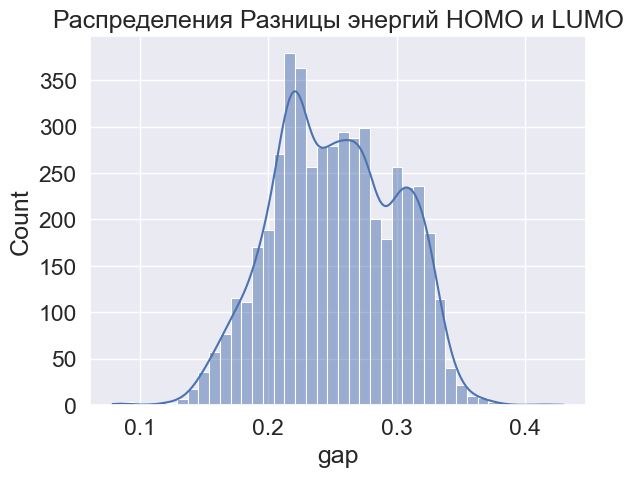

In [569]:
#Гистограмма ( показывает распределение значений в выбранном столбце. 
#Позволяет оценить форму распределения (нормальное, скошенное), наличие выбросов и частоту встречаемости значений.)
sns.histplot(df_after_FS['gap'], kde=True)
plt.title("Распределения gap - Разницы энергий HOMO и LUMO")
plt.show()

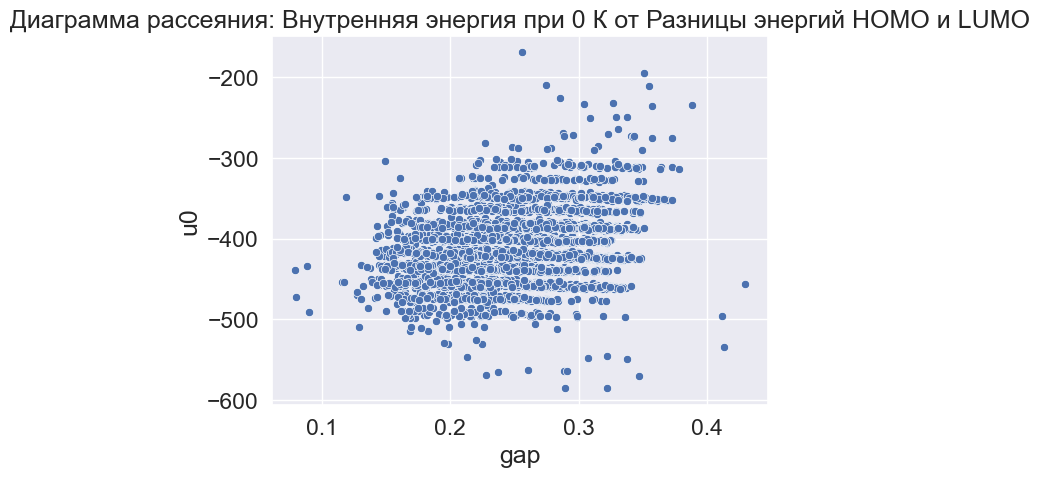

In [570]:
# 2.  Диаграмма рассеяния показывает зависимость между двумя переменными.
# Позволяет выявить линейную или нелинейную корреляцию, наличие кластеров и выбросов.
sns.scatterplot(x=df_after_FS['gap'], y=df_after_FS['u0'])
plt.title("Диаграмма рассеяния: Внутренняя энергия при 0 К от Разницы энергий HOMO и LUMO")
plt.show()

In [572]:
# Строим boxplot для столбца 'gap'
fig = px.box(df_after_FS, y="gap", title="Boxplot для Разницы энергий HOMO и LUMO")
fig.update_layout(template='plotly_dark')
# Показываем график
fig.show()

In [575]:
fig = px.scatter(df_after_FS, x='gap', y='u0', trendline="ols", title="Диаграмма рассеяния с линейной регрессией")
fig.update_layout(template='plotly_dark')
fig.show()

In [16]:
#Подсчитать кореляцию gap u0 и annova

In [23]:
correlation = df['gap'].corr(df['u0'])
print(correlation)

0.29795337193158705
